In [1]:
import numpy as np
import pandas as pd
from typing import Tuple
from scipy.optimize import minimize
import yfinance as yf

# ============================================================
# 1) PREISDATEN LADEN
# ============================================================

tickers = ["AAPL", "MSFT", "GOOG"]

data = yf.download(tickers, period="2y", auto_adjust=False)

# Spalte auswählen: Adj Close oder Close
if "Adj Close" in data.columns.get_level_values(0):
    adj_close = data["Adj Close"]
else:
    adj_close = data["Close"]

print("Preisdaten geladen:\n", adj_close.tail())

# ============================================================
# 2) RENDITEN BERECHNEN
# ============================================================

returns_df = adj_close.pct_change().dropna()
print("\nRenditen geladen:")
print(returns_df.head())
print("Shape:", returns_df.shape)

returns_array = returns_df.values  # NumPy-Array

# ============================================================
# 3) MEAN-VARIANCE KRITERIUM
# ============================================================

def mv_criterion(
    weights: np.ndarray,
    returns: np.ndarray,
    risk_aversion: float = 3.0,
    initial_wealth: float = 1.0,
    excess_return_target: float = 0.25 / 100,
) -> float:

    w = np.asarray(weights, dtype=float).reshape(-1)
    r = np.asarray(returns, dtype=float)

    lam = float(risk_aversion)
    W0 = float(initial_wealth)
    W_bar = W0 * (1 + excess_return_target)

    port_ret = r @ w
    mu = np.mean(port_ret)
    sigma = np.std(port_ret, ddof=1)

    term1 = W_bar ** (1 - lam) / (1 + lam)
    term2 = W_bar ** (-lam) * W0 * mu
    term3 = lam / 2 * W_bar ** (-1 - lam) * W0**2 * sigma**2

    utility = term1 + term2 - term3

    return -utility  # Minimierer soll maximieren


def mv_criterion_with_stats(weights, returns, **kwargs) -> Tuple[float, float, float]:
    w = np.asarray(weights, dtype=float)
    r = np.asarray(returns, dtype=float)

    port_ret = r @ w
    mu = np.mean(port_ret)
    sigma = np.std(port_ret, ddof=1)

    value = mv_criterion(w, r, **kwargs)
    return value, mu, sigma

# ============================================================
# 4) OPTIMIERUNG
# ============================================================

n_assets = returns_array.shape[1]
w0 = np.ones(n_assets) / n_assets

constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * n_assets

result = minimize(
    mv_criterion,
    w0,
    args=(returns_array,),
    method="SLSQP",
    constraints=constraints,
    bounds=bounds,
)

if not result.success:
    print("Optimierung NICHT erfolgreich:", result.message)
else:
    opt_w = result.x
    value, mu_opt, sigma_opt = mv_criterion_with_stats(opt_w, returns_array)

    print("\nOptimierung erfolgreich!")
    print("Optimale Gewichte:", opt_w)
    print("Erwartete Rendite:", mu_opt)
    print("Volatilität:", sigma_opt)


[*********************100%***********************]  3 of 3 completed

Preisdaten geladen:
 Ticker            AAPL        GOOG        MSFT
Date                                          
2025-12-01  283.100006  315.119995  486.739990
2025-12-02  286.190002  316.019989  490.000000
2025-12-03  284.149994  320.619995  477.730011
2025-12-04  280.700012  318.390015  480.839996
2025-12-05  278.779999  322.089996  483.160004

Renditen geladen:
Ticker          AAPL      GOOG      MSFT
Date                                    
2023-12-07  0.010139  0.053412  0.005830
2023-12-08  0.007412 -0.013073  0.008842
2023-12-11 -0.012927 -0.014198 -0.007830
2023-12-12  0.007920 -0.007869  0.008295
2023-12-13  0.016692  0.002469 -0.000027
Shape: (501, 3)

Optimierung erfolgreich!
Optimale Gewichte: [0.33333333 0.33333333 0.33333333]
Erwartete Rendite: 0.0011869853837342328
Volatilität: 0.013564577198830316


In [2]:
# Annahme: returns_df ist ein DataFrame mit Renditen (z.B. adj_close.pct_change().dropna())
data = returns_df.values   # (n_periods, n_assets)

# Train-/Test-Split
split = int(0.7 * len(data))
train_set = data[:split, :]   # In-Sample
test_set = data[split:, :]    # Out-of-Sample (für spätere Auswertung)

# Anzahl der Assets
n = train_set.shape[1]

# Startgewichte (gleichgewichtet, Summe = 1)
x0 = np.ones(n) / n

# Nebenbedingung: Summe der Gewichte = 1
cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}

# Bounds: keine Short-Sales, Gewichte zwischen 0 und 1
Bounds = [(0.0, 1.0)] * n

# Optimierung
res_MV = minimize(
    mv_criterion,       # unsere Funktion von oben
    x0,
    args=(train_set,),  # wichtig: Komma, damit es ein Tupel ist
    method="SLSQP",
    bounds=Bounds,
    constraints=[cons],
    options={'disp': True}
)

X_MV = res_MV.x  # optimale Gewichte (In-Sample)
print("Optimale Gewichte (Train):", X_MV)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.24904156194815585
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Optimale Gewichte (Train): [0.33333333 0.33333333 0.33333333]


In [3]:
# Annahme: returns_df existiert bereits und mv_criterion ist definiert

# 1) Daten aufräumen und in NumPy-Array umwandeln
returns_clean = (
    returns_df
    .sort_index()      # sicherstellen, dass die Daten zeitlich sortiert sind
    .dropna()          # fehlende Werte entfernen
    .to_numpy()        # (n_periods, n_assets)
)

n_obs, n_assets = returns_clean.shape

# 2) Train-/Test-Split (70% / 30%), immer relativ zu den vorhandenen Daten
split_idx = int(0.7 * n_obs)
train_set = returns_clean[:split_idx, :]   # In-Sample
test_set  = returns_clean[split_idx:, :]   # Out-of-Sample (für spätere Auswertung)

# 3) Startgewichte: gleichgewichtet, Summe = 1
x0 = np.full(n_assets, 1.0 / n_assets, dtype=float)

# 4) Nebenbedingung: Summe der Gewichte = 1
constraints = (
    {"type": "eq", "fun": lambda w: np.sum(w) - 1.0},
)

# 5) Bounds: keine Short-Sales, 0 ≤ w ≤ 1
bounds = [(0.0, 1.0)] * n_assets

# 6) Optimierung
res_MV = minimize(
    mv_criterion,
    x0,
    args=(train_set,),          # Trainingsdaten als Argument
    method="SLSQP",
    constraints=constraints,
    bounds=bounds,
    options={"maxiter": 1000, "ftol": 1e-9, "disp": False},
)

# 7) Ergebnisse prüfen und Gewichte ggf. nachjustieren
if not res_MV.success:
    raise RuntimeError(f"Optimierung fehlgeschlagen: {res_MV.message}")

X_MV = res_MV.x

# numerische Kleinigkeiten korrigieren (negative Rundungsreste, Summe ≈ 1)
X_MV = np.clip(X_MV, 0.0, None)
X_MV = X_MV / X_MV.sum()

print("Optimale Gewichte (Train):", X_MV)


Optimale Gewichte (Train): [0.03868945 0.58460128 0.37670928]


[*********************100%***********************]  3 of 3 completed


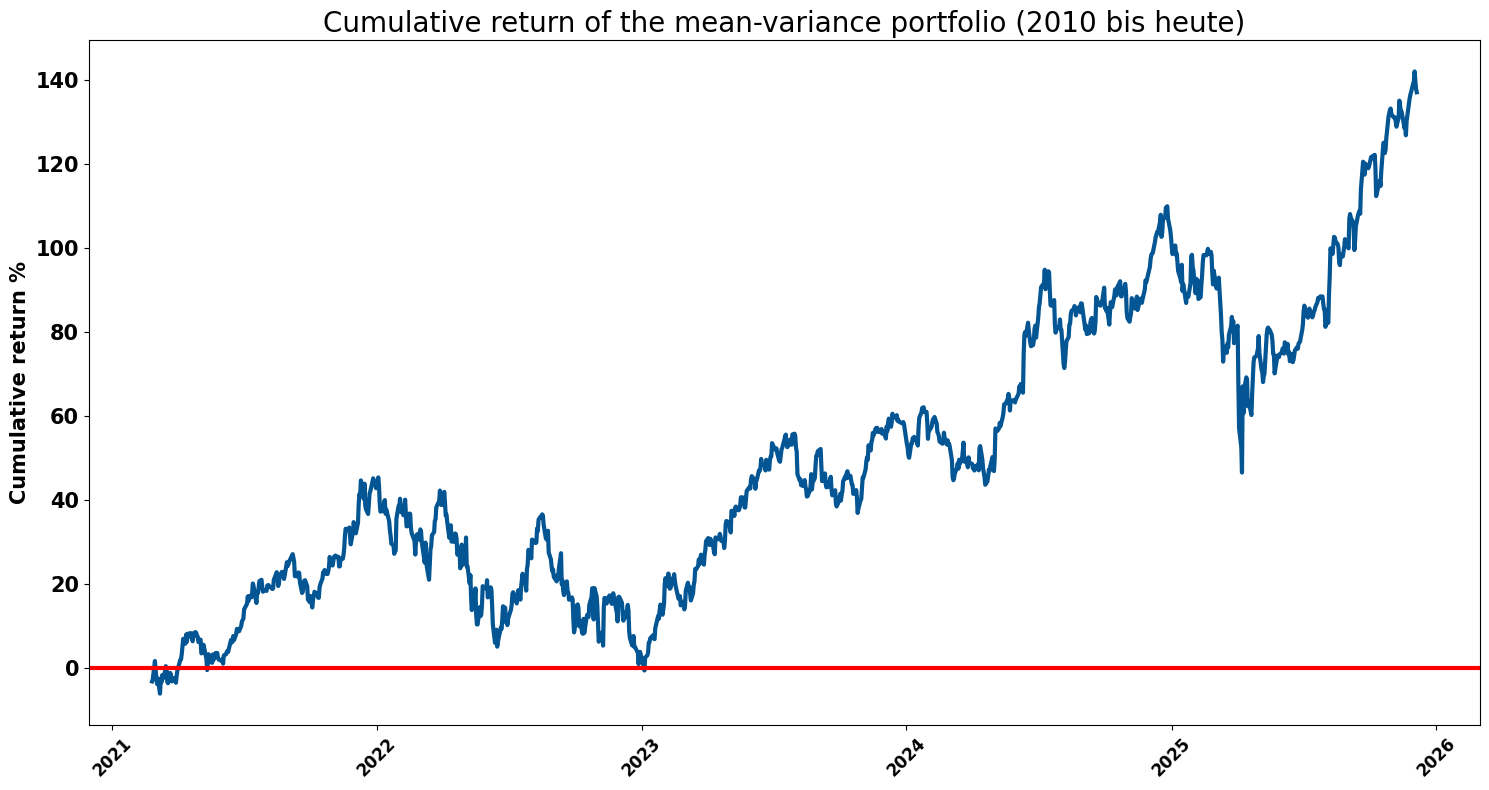

In [9]:
import matplotlib.pyplot as plt
from datetime import date

# Zeitraum: immer 2010 bis heute
start_date = "2010-01-01"
end_date = date.today().strftime("%Y-%m-%d")

# Daten neu laden (automatische Aktualisierung)
raw = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# Adj Close oder Close auswählen
if "Adj Close" in raw.columns.get_level_values(0):
    prices = raw["Adj Close"]
else:
    prices = raw["Close"]

# Renditen aus dem kompletten Zeitraum
returns_df = prices.pct_change().dropna()

# --------------------------------------------
# Train/Test Split neu anwenden (70% / 30%)
# --------------------------------------------
data = returns_df.values
n_obs = len(data)
split = int(0.7 * n_obs)

train_set = data[:split, :]
test_set  = data[split:, :]

# Portfolio Returns für Testset
portfolio_return_MV = test_set @ X_MV

# Kumulierte Renditen (geometrisch)
cum_return_MV = np.cumprod(1 + portfolio_return_MV) - 1

# Datumsindex passend zum Testset
dates_test = returns_df.index[split:]

# --------------------------------------------
# Plot: X-Achse mit Jahresdaten
# --------------------------------------------
plt.figure(figsize=(15, 8))
plt.plot(dates_test, cum_return_MV * 100, linewidth=3, color="#035593")

plt.title("Cumulative return of the mean-variance portfolio (2010 bis heute)", size=20)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")

plt.xticks(size=12, fontweight="bold", rotation=45)
plt.yticks(size=15, fontweight="bold")

plt.axhline(0, color="r", linewidth=3)
plt.tight_layout()
plt.show()


In [ ]:
from Backtest import *
backtest_static_portfolio(X_MV, test_set, CR=True)

# Zeitraum: immer ab 2010 bis heute
start_date = "2010-01-01"
end_date = date.today().strftime("%Y-%m-%d")

# Kursdaten bis heute laden
raw = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

# Close-Preise verwenden und nur volle Zeilen behalten
prices = raw["Close"].dropna(how="any")

# Renditen berechnen
returns_df = prices.pct_change().dropna()

# Train/Test-Split (70 % / 30 %) – Testset geht automatisch bis heute
data = returns_df.to_numpy()
split = int(0.7 * len(data))
train_set = data[:split, :]
test_set  = data[split:, :]

# Backtest mit deinem bereits berechneten Portfolio X_MV
backtest_static_portfolio(X_MV, test_set, CR=True)


[*********************100%***********************]  3 of 3 completed


NameError: name 'backtest_static_portfolio' is not defined